# Comparing MAGeT ans SUIT results
## Data: 
    - 1. Cerebellar SUIT segmentation; 
         - SUIT: Left/right 1-X+Dentate+Interposed+Fastigial and Vermis
    - 2. Cerebellar MAGeTBrain [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)
        - MAGeT: Left/right 1-X+WhiteMatter(CM)
          maget_df.columns=
          ['L_I_II', 'L_III', 'L_IV', 'L_V', 'L_VI', 'L_Crus_I', 'L_Crus_II', 'L_VIIB', 'L_VIIIA', 'L_VIIIB', 'L_IX', 'L_X', 'L_CM', 
           'R_I_II', 'R_III', 'R_IV', 'R_V', 'R_VI', 'R_Crus_I', 'R_Crus_II', 'R_VIIB', 'R_VIIIA', 'R_VIIIB', 'R_IX', 'R_X', 'R_CM']
          No vermis in MAGeT as well.
## Cohorts
- The augmented cohort 211: MNI ET/ matched NC (34/177).

## Tasks: GLM for 
 - Compare MAGeT and SUIT results correlation;
 - Compare MAGeT and SUIT results in GLM; 

## Covariates
- Age, Sex, intracranial volume (eTIV/cerebellar volume), cohort.

In [1]:
#reading/merging/selecting data
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('/codes')

data_dir = Path("/codes/tab_data")
# data files
matched_des_all_file = data_dir/ 'matched_Des-all_qced.csv'
matched_DKT_all_file = data_dir/ 'matched_DKT-all_qced.csv'
data_df = pd.read_csv(matched_des_all_file , sep=',', header=0, index_col=0);

220228-05:24:36,660 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.5.0


In [2]:
#GLM analysis and non-parametric comparison
SUIT_l_labels = ['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 
                 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 
                 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels = ['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII',
                 'Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X',
                 'Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 
                 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
MAGeT_l_labels = ['L_I_IV',  'L_V', 'L_VI', 'L_Crus_I', 'L_Crus_II', 
                 'L_VIIB', 'L_VIIIA', 'L_VIIIB', 'L_IX', 'L_X'];  # NO  'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'
MAGeT_r_labels = ['R_I_IV','R_V','R_VI','R_Crus_I','R_Crus_II',
                 'R_VIIB','R_VIIIA','R_VIIIB','R_IX','R_X'];  # NO  'Right_Dentate','Right_Interposed','Right_Fastigial'

length_lobule_list=len(MAGeT_l_labels)

qc_list = ['freesurfer_score', 'suit_score', 'maget_score']
analysis_list = ['age','sex','group', 'cohort','site','eTIV', 'is_adni', 'is_mni', 'is_ppmi', 'male',
                 'SupraTentorialVol', 'SupraTentorialVolNotVent',
                 'Left_Cerebellum_White_Matter','Left_Cerebellum_Cortex','Right_Cerebellum_White_Matter','Right_Cerebellum_Cortex',
                 'Cerebellum_White_Matter', 'Cerebellum_Cortex', 'cerebellumVol', 'InfraTentorialVol']+SUIT_l_labels+SUIT_r_labels+SUIT_v_labels+MAGeT_l_labels+MAGeT_r_labels+qc_list;


saving...


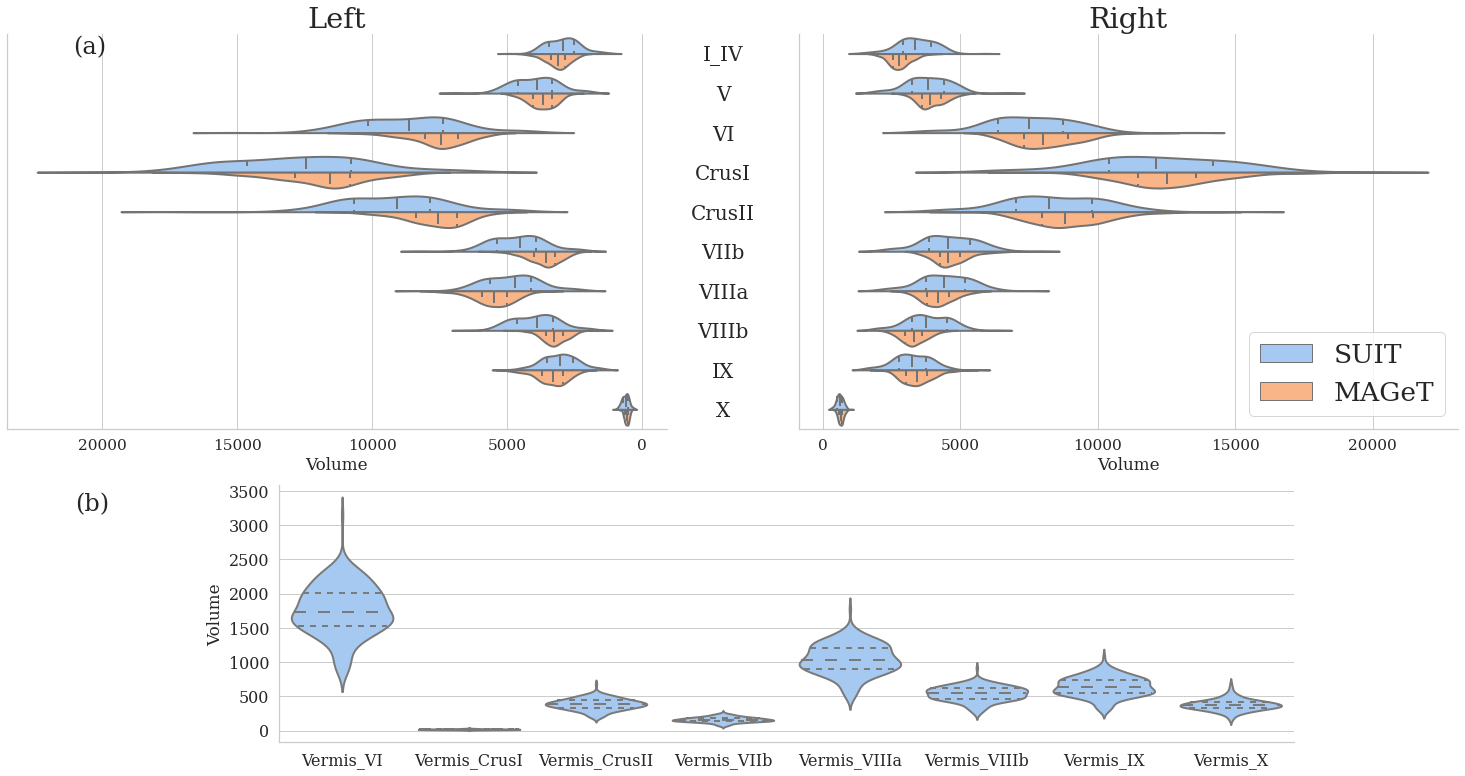

In [17]:
# distribution plot for all the suit and maget
figure_size=(26, 16); 
FONT_SCALE=2.4;
legend_font_size=24
save_fig=0

lobule_list = ['I_IV', 'V', 'VI', 'CrusI', 'CrusII', 'VIIb', 'VIIIa', 'VIIIb', 'IX', 'X'];
dis_df=data_df.copy()

def pivot_cere_df(df, col_list, loc_str, pipeline_str):
    # creat melted dataframe (sub,roi,loc,vol,pipeline) from visualization from raw dataframe (sub*ROI)
    df.columns = col_list; 
    df.loc[:,'sub']=df.index;
    df = pd.melt(df, id_vars='sub', value_vars=col_list, var_name='Lobule', value_name='Volume');
    df.loc[:,'Hemisphere']=loc_str; df.loc[:,'Pipeline']=pipeline_str;
    return df.copy()

suit_l_df_ = dis_df.loc[:, SUIT_l_labels[:length_lobule_list]].copy(); 
suit_l_df_ = pivot_cere_df(suit_l_df_, lobule_list, 'Left', 'SUIT')
suit_r_df_ = dis_df.loc[:, SUIT_r_labels[:length_lobule_list]].copy(); 
suit_r_df_ = pivot_cere_df(suit_r_df_, lobule_list, 'Right', 'SUIT')
suit_v_df_ = dis_df.loc[:, SUIT_v_labels].copy(); 
suit_v_df_ = pivot_cere_df(suit_v_df_, SUIT_v_labels, 'Vermis', 'SUIT')

maget_l_df_ = dis_df.loc[:, MAGeT_l_labels].copy(); 
maget_l_df_ = pivot_cere_df(maget_l_df_, lobule_list, 'Left', 'MAGeT')
maget_r_df_ = dis_df.loc[:, MAGeT_r_labels].copy(); 
maget_r_df_ = pivot_cere_df(maget_r_df_, lobule_list, 'Right', 'MAGeT')

lobule_df = pd.concat([suit_l_df_, suit_r_df_, maget_l_df_, maget_r_df_])

## vis
f1 = plt.figure(figsize=figure_size, facecolor='w', edgecolor='lightgray')
gs = f1.add_gridspec(2, 2)
ax1 = f1.add_subplot(gs[0, 0])
ax2 = f1.add_subplot(gs[0, 1])
ax3 = f1.add_subplot(gs[1, :])

# Fig. a
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.violinplot(data=lobule_df[lobule_df['Hemisphere']=='Left'], x="Volume", y="Lobule", hue="Pipeline",
               split=True, inner="quartile",  scale='count', bw='silverman', orient='h',
               ax=ax1, linewidth=2, saturation=0.9)
ax1.invert_xaxis()
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(True)
ax1.set(yticklabels=[])
ax1.set(ylabel=None)
ax1.set_title('Left')
pos1 = ax1.get_position()
ax1.set_position([pos1.x0, pos1.y0,  pos1.width, pos1.height])
#sub_figure index
ax1.text(0.1, 0.95, '(a)', transform=ax1.transAxes, fontsize=legend_font_size)
# Fig. b
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.despine();
sns.violinplot(data=lobule_df[lobule_df['Hemisphere']=='Right'], x="Volume", y="Lobule", hue="Pipeline",
               split=True, inner="quartile",  scale='count', bw='silverman', orient='h', 
               ax=ax2, linewidth=2, saturation=0.9)
ax2.get_yaxis().set_visible(True)
ax2.get_xaxis().set_visible(True)
ax2.set_title('Right')
ax2.set(ylabel=None)
ax2.legend(loc='lower right')
# ceter y ticklabels
for tick in ax2.yaxis.get_majorticklabels():
    tick.set_horizontalalignment('center')
    pos_tmp=tick.get_position()
    tick.set_position((pos_tmp[0]-0.1,pos_tmp[1]))
    tick.set(fontsize=20)
# Fig. c
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE-1)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.despine();
sns.violinplot(data=suit_v_df_, y="Volume", x="Lobule",
               inner="quartile",  scale='width', bw='silverman', orient='v', 
               ax=ax3, linewidth=2, color=sns.color_palette("pastel")[0], saturation=0.9)
ax3.get_yaxis().set_visible(True)
ax3.set(xlabel=None)
ax3.tick_params(axis='both', which='major', labelsize=16)
pos3 = ax3.get_position()
ax3.set_position([pos3.x0+0.145, pos3.y0+0.14,  pos3.width*0.7, pos3.height*0.65])
ax3.text(-0.2, 0.9, '(b)', transform=ax3.transAxes, fontsize=legend_font_size)
if save_fig: print('saving...'); f1.savefig("Fig2-lobule_distr.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1)

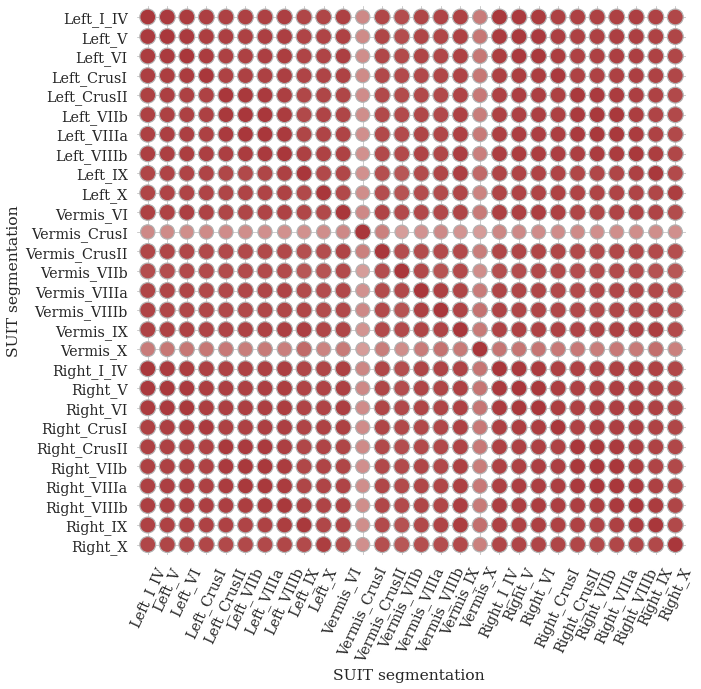

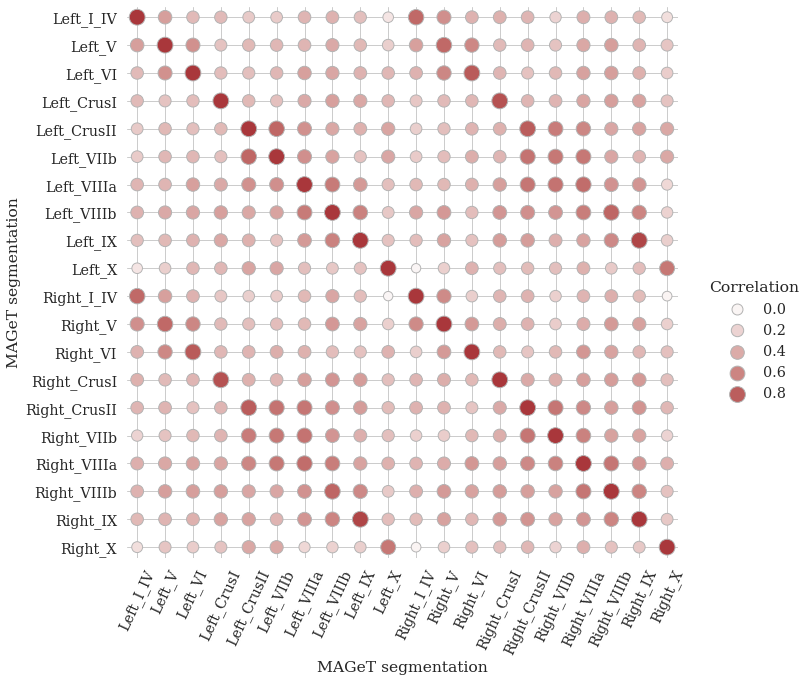

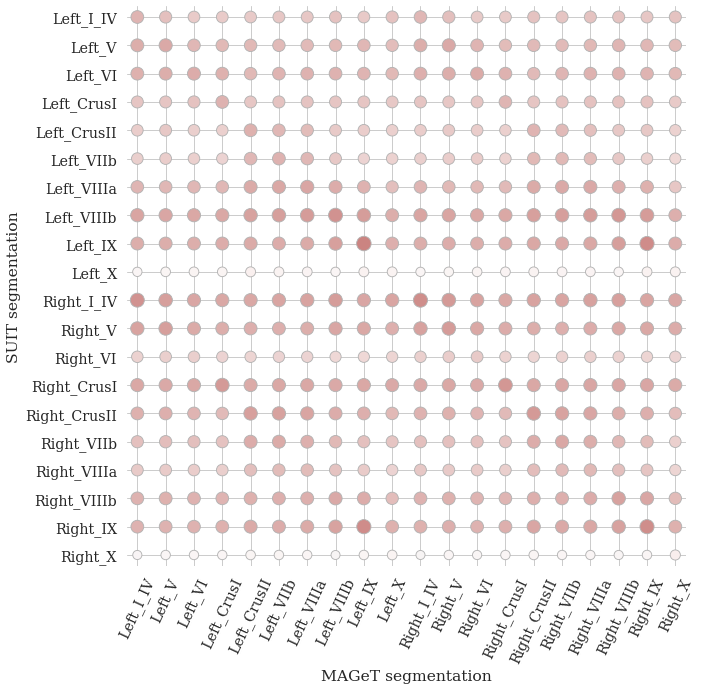

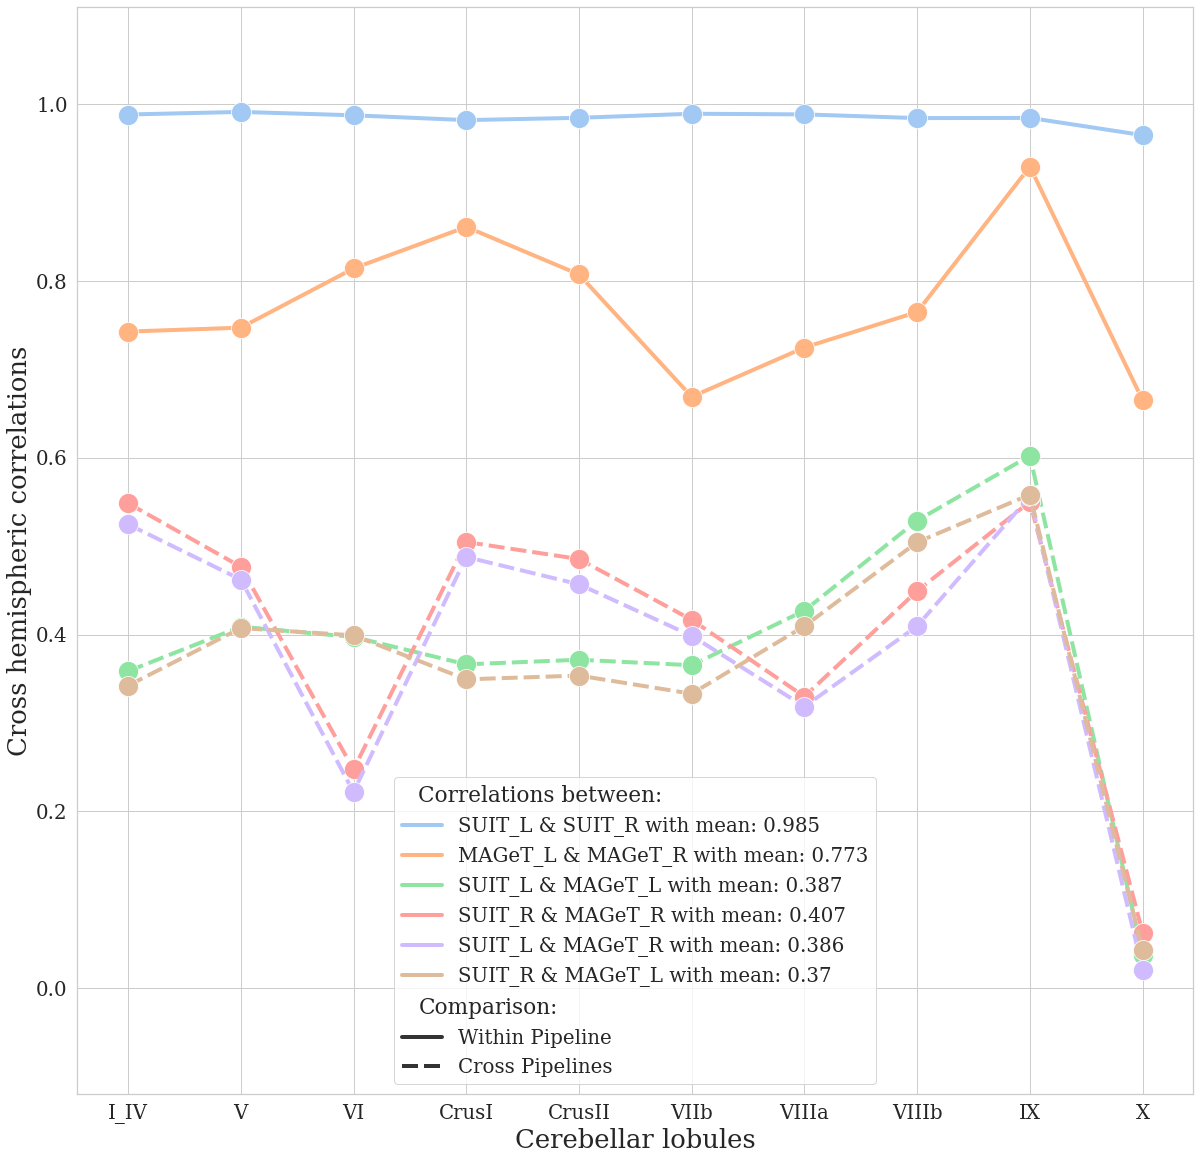

In [4]:
# correlation plot for all the suit and maget results
# distribution plot for all the suit and maget
figure_size=(20, 20); 
FONT_SCALE=1.3;
x_tick_rotation=65
save_fig=0

lobule_list = ['I_IV', 'V', 'VI', 'CrusI', 'CrusII', 'VIIb', 'VIIIa', 'VIIIb', 'IX', 'X'];
SUIT_l_labels_= SUIT_l_labels[:length_lobule_list]; SUIT_r_labels_=SUIT_r_labels[:length_lobule_list];
suit_labels=SUIT_l_labels_+SUIT_r_labels_;

vis_df=data_df.copy()
# prepare data
suit_df_ = vis_df.loc[:,SUIT_l_labels_+SUIT_v_labels+SUIT_r_labels_].copy()
maget_df_ = vis_df.loc[:,MAGeT_l_labels+MAGeT_r_labels].copy()
sm_df_ = vis_df.loc[:,SUIT_l_labels_+SUIT_r_labels_+MAGeT_l_labels+MAGeT_r_labels].copy()

# Fig. a,b,c Inner correlatoin
suit_corr_df =suit_df_.corr(); suit_corr_long_df = suit_corr_df.stack().reset_index(name="Correlation")
maget_corr_df=maget_df_.corr(); 
maget_corr_df.index=suit_labels; maget_corr_df.columns=suit_labels;
maget_corr_long_df = maget_corr_df.stack().reset_index(name="Correlation")

# cross correlation
sm_corr_df_ = sm_df_.corr();
sm_cross_corr_df_ = sm_corr_df_.iloc[0:length_lobule_list*2,length_lobule_list*2:];
sm_cross_corr_df_.index=suit_labels; sm_cross_corr_df_.columns=suit_labels;
sm_cross_corr_long_df_ = sm_cross_corr_df_.stack().reset_index(name="Correlation")

# Fig.d: cross correlation lines
sl_sr_ = np.diag(suit_corr_df, length_lobule_list+len(SUIT_v_labels));
sl_sr_df= pd.DataFrame({'Correlation':sl_sr_, 'Lobules':lobule_list}); 
sl_sr_df['Correlations between:']='SUIT_L & SUIT_R with mean: '+str(round(np.mean(sl_sr_), 3));
sl_sr_df['Comparison:']='Within Pipeline'
ml_mr_ = np.diag(maget_corr_df, length_lobule_list);
ml_mr_df= pd.DataFrame({'Correlation':ml_mr_, 'Lobules':lobule_list}); 
ml_mr_df['Correlations between:']='MAGeT_L & MAGeT_R with mean: '+str(round(np.mean(ml_mr_), 3));
ml_mr_df['Comparison:']='Within Pipeline'
sl_ml_ = np.diag(sm_cross_corr_df_)[:length_lobule_list]; 
sl_ml_df= pd.DataFrame({'Correlation':sl_ml_, 'Lobules':lobule_list}); 
sl_ml_df['Correlations between:']='SUIT_L & MAGeT_L with mean: '+str(round(np.mean(sl_ml_), 3));
sl_ml_df['Comparison:']='Cross Pipelines'
sr_mr_ = np.diag(sm_cross_corr_df_)[length_lobule_list:];
sr_mr_df= pd.DataFrame({'Correlation':sr_mr_, 'Lobules':lobule_list}); 
sr_mr_df['Correlations between:']='SUIT_R & MAGeT_R with mean: '+str(round(np.mean(sr_mr_), 3));
sr_mr_df['Comparison:']='Cross Pipelines'
sl_mr_ = np.diag(sm_cross_corr_df_, length_lobule_list);
sl_mr_df= pd.DataFrame({'Correlation':sl_mr_, 'Lobules':lobule_list}); 
sl_mr_df['Correlations between:']='SUIT_L & MAGeT_R with mean: '+str(round(np.mean(sl_mr_), 3));
sl_mr_df['Comparison:']='Cross Pipelines'
sr_ml_ = np.diag(sm_cross_corr_df_, -length_lobule_list);
sr_ml_df= pd.DataFrame({'Correlation':sr_ml_, 'Lobules':lobule_list}); 
sr_ml_df['Correlations between:']='SUIT_R & MAGeT_L with mean: '+str(round(np.mean(sr_ml_), 3));
sr_ml_df['Comparison:']='Cross Pipelines'

sm_cros_corr_vis_df = pd.concat([sl_sr_df, ml_mr_df, sl_ml_df, sr_mr_df, sl_mr_df, sr_ml_df])

# Fig2. a
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
g1 = sns.relplot(
    data=suit_corr_long_df,
    x="level_0", y="level_1", hue="Correlation", size="Correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-0.2, 0.8), legend=False
)

# Tweak the figure
g1.set(xlabel="", ylabel="", aspect="equal")
g1.despine(left=True, bottom=True)
g1.ax.margins(.02)
g1.set_xlabels('SUIT segmentation ')
g1.set_ylabels('SUIT segmentation')
for label in g1.ax.get_xticklabels():
    label.set_rotation(x_tick_rotation)
g1.tight_layout()
if save_fig: print('saving...'); g1.savefig("Fig2-SUIT_corr.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1);

# Fig2. b
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
g2 = sns.relplot(
    data=maget_corr_long_df,
    x="level_0", y="level_1", hue="Correlation", size="Correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7", legend='auto',
    height=10, sizes=(50, 250), size_norm=(-0.2, 0.8),
)

# Tweak the figure
g2.set(xlabel="", ylabel="", aspect="equal")
g2.despine(left=True, bottom=True)
g2.ax.margins(.02)
g2.set_xlabels('MAGeT segmentation')
g2.set_ylabels('MAGeT segmentation')
#g2.legend.
for label in g2.ax.get_xticklabels():
    label.set_rotation(x_tick_rotation)
for artist in g2.legend.legendHandles:
    artist.set_edgecolor(".7")
g2.tight_layout()
if save_fig: print('saving...'); g2.savefig("Fig2-MAGeT_corr.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1);

# Fig2. c
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
g3 = sns.relplot(
    data=sm_cross_corr_long_df_,
    x="level_0", y="level_1", hue="Correlation", size="Correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7", legend=False,
    height=10, sizes=(50, 250), size_norm=(-0.2, 0.8),
)
# Tweak the figure
g3.set(xlabel="", ylabel="", aspect="equal")
g3.despine(left=True, bottom=True)
g3.ax.margins(.02)
g3.set_ylabels('SUIT segmentation')
g3.set_xlabels('MAGeT segmentation')
#g2.legend.
for label in g3.ax.get_xticklabels():
    label.set_rotation(x_tick_rotation)
g3.tight_layout()
if save_fig: print('saving...'); g3.savefig("Fig2-SUIT-MAGeT_cross-corr.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1);

# Fig2. d
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE+0.5)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
f2, ax4 = plt.subplots(figsize=figure_size, facecolor='w', edgecolor='lightgray') 
sns.lineplot(data=sm_cros_corr_vis_df, y="Correlation", x="Lobules", hue="Correlations between:", #size="Correlation", style="Correlation between:", 
             style='Comparison:', style_order=['Within Pipeline','Cross Pipelines'], marker='o', markersize=20, lw=4,
             ax=ax4)
ax4.set(ylim=[-0.12,1.11])
ax4.set_xlabel('Cerebellar lobules', fontsize='large')
ax4.set_ylabel('Cross hemispheric correlations', fontsize='large')
for legobj in ax4.legend_.legendHandles:
    legobj.set_linewidth(4)
    
if save_fig: print('saving...'); f2.savefig("Fig2-SUIT-MAGeT_cross-corr_line.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1);

In [7]:
# calculate the summary statistics of the correlation matrics
def corr_stats(df, title_str):
    low_triag=np.tril(df,-1)
    print('dim=',df.shape)
    low_triag_vec=low_triag[low_triag!=0]
    print(title_str, 'Mean and std of off-diagnal elements: \n', low_triag_vec.mean(),' ~ ', low_triag_vec.std())
#suit_mean_all=suit_corr_df.mean().mean()
corr_stats(suit_corr_df,  'SUIT corr')
corr_stats(maget_corr_df,'MAGeT corr')
corr_stats(sm_cross_corr_df_,'Cross SUIT and MAGeT corr')
print(sm_cross_corr_df_.mean())
print(sm_cross_corr_df_.std())

dim= (28, 28)
SUIT corr Mean and std of off-diagnal elements: 
 0.8900934489622826  ~  0.12105119010595121
dim= (20, 20)
MAGeT corr Mean and std of off-diagnal elements: 
 0.4091520825935776  ~  0.1522917468024745
dim= (20, 20)
Cross SUIT and MAGeT corr Mean and std of off-diagnal elements: 
 0.3170074211306495  ~  0.10355528650907905
Left_I_IV       0.274939
Left_V          0.344944
Left_VI         0.363085
Left_CrusI      0.280958
Left_CrusII     0.262872
Left_VIIb       0.254906
Left_VIIIa      0.362025
Left_VIIIb      0.446926
Left_IX         0.420326
Left_X          0.021476
Right_I_IV      0.449279
Right_V         0.409995
Right_VI        0.204795
Right_CrusI     0.424172
Right_CrusII    0.386362
Right_VIIb      0.324797
Right_VIIIa     0.264332
Right_VIIIb     0.373455
Right_IX        0.406550
Right_X        -0.006191
dtype: float64
Left_I_IV       0.031647
Left_V          0.029254
Left_VI         0.021062
Left_CrusI      0.028455
Left_CrusII     0.051374
Left_VIIb       0.05907

In [8]:
# MAGeT results for MNI cohort
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts
from utils_.utils import glm_test, rep_model

# basic settings
alpha_=0.05

glm_df=data_df.copy()
tar_list_suit = ['Left_CrusI', 'Left_CrusII', 'Right_CrusI','Right_CrusII']
tar_list_maget = ['L_Crus_I', 'L_Crus_II', 'R_Crus_I', 'R_Crus_II']

# MAGeT test
alpha_=0.05
glm_df=data_df.copy()
print("Sample sizes for ET/NC: ")
print('\t',glm_df[glm_df['group']=='ET'].shape[0], ' / ',glm_df[glm_df['group']=='NC'].shape[0])
print("tested ROIs:")
print('\t',', '.join(tar_list_suit))

print("\nGLM for MAGeT cerebellum volumetry (age/sex/eTIV) on matched cohort:")
# 1.GLM for cerebellum volumetry with covariates:  age/sex/cohort/group/eTIV
covariate_model_eTIV_str = '~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict_etiv = glm_test(glm_df, tar_list_maget, covariate_model_eTIV_str);
rep_model(covariate_dict_etiv, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});

# 2. GLM for cerebellum volumetry with covariates: age/sex/cohort/group/cerebellumVol.
print("\nGLM for MAGeT cerebellum volumetry (age/sex/cerebellumVol) on matched cohort:")
covariate_model_cere_str = '~age+C(sex, Treatment(reference="F"))+cerebellumVol+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict_cere = glm_test(glm_df, tar_list_maget, covariate_model_cere_str);
rep_model(covariate_dict_cere, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});

# Recall SUIT test results:
print("\nGLM for SUIT cerebellum volumetry (age/sex/eTIV) on matched cohort:")
# 1.GLM for cerebellum volumetry with covariates:  age/sex/cohort/group/eTIV
covariate_model_eTIV_str = '~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict_etiv = glm_test(glm_df, tar_list_suit, covariate_model_eTIV_str);
rep_model(covariate_dict_etiv, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});

# 2. GLM for cerebellum volumetry with covariates: age/sex/cohort/group/cerebellumVol.
print("\nGLM for SUIT cerebellum volumetry (age/sex/cerebellumVol) on matched cohort:")
covariate_model_cere_str = '~age+C(sex, Treatment(reference="F"))+cerebellumVol+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict_cere = glm_test(glm_df, tar_list_suit, covariate_model_cere_str);
rep_model(covariate_dict_cere, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});

Sample sizes for ET/NC: 
	 34  /  177
tested ROIs:
	 Left_CrusI, Left_CrusII, Right_CrusI, Right_CrusII

GLM for MAGeT cerebellum volumetry (age/sex/eTIV) on matched cohort:
L_Crus_I : no significant result with p= 0.16539656754121856
L_Crus_II : no significant result with p= 0.95886446868607
R_Crus_I : no significant result with p= 0.7507758508649083
R_Crus_II : no significant result with p= 0.9687736616096736

GLM for MAGeT cerebellum volumetry (age/sex/cerebellumVol) on matched cohort:
L_Crus_I : no significant result with p= 0.23332885126494263
L_Crus_II : no significant result with p= 0.6249523217545141
R_Crus_I : no significant result with p= 0.8959356051717151
R_Crus_II : no significant result with p= 0.6369655833967061

GLM for SUIT cerebellum volumetry (age/sex/eTIV) on matched cohort:
Left_CrusI : no significant result with p= 0.13001640407923876
Left_CrusII : no significant result with p= 0.1637369404756499
Right_CrusI : no significant result with p= 0.13735959915423387
Righ

,Left_I_IV,Left_V,Left_VI,Left_CrusI,Left_CrusII,Left_VIIb,Left_VIIIa,Left_VIIIb,Left_IX,Left_X,...,R_I_IV,R_V,R_VI,R_Crus_I,R_Crus_II,R_VIIB,R_VIIIA,R_VIIIB,R_IX,R_X
Left_I_IV,1.000000,0.982413,0.970592,0.953870,0.946796,0.948737,0.952097,0.960861,0.925165,0.926851,...,0.524856,0.444865,0.210738,0.414996,0.370309,0.292256,0.249945,0.361967,0.365225,-0.032244
Left_V,0.982413,1.000000,0.983613,0.962233,0.954874,0.951804,0.953387,0.960109,0.930062,0.933770,...,0.465945,0.462415,0.225154,0.412533,0.377500,0.311087,0.240083,0.373522,0.363545,-0.003257
Left_VI,0.970592,0.983613,1.000000,0.969719,0.949588,0.951627,0.954875,0.962199,0.934006,0.934190,...,0.422642,0.404648,0.221983,0.419310,0.353221,0.298570,0.227990,0.363064,0.360844,-0.008905
Left_CrusI,0.953870,0.962233,0.969719,1.000000,0.944603,0.948537,0.952569,0.955339,0.929957,0.936525,...,0.415261,0.383665,0.196512,0.487894,0.327627,0.283690,0.223559,0.351818,0.369421,-0.009016
Left_CrusII,0.946796,0.954874,0.949588,0.944603,1.000000,0.986493,0.979881,0.960861,0.918374,0.927221,...,0.417301,0.376575,0.194281,0.403851,0.456973,0.392032,0.303491,0.371309,0.400116,0.010689
Left_VIIb,0.948737,0.951804,0.951627,0.948537,0.986493,1.000000,0.995030,0.972454,0.913768,0.932028,...,0.436444,0.377571,0.201797,0.418362,0.445399,0.398736,0.315717,0.375703,0.393732,0.000162
Left_VIIIa,0.952097,0.953387,0.954875,0.952569,0.979881,0.995030,1.000000,0.979941,0.922819,0.933572,...,0.444530,0.387917,0.198251,0.416674,0.434477,0.380951,0.318625,0.380041,0.399444,-0.007760
Left_VIIIb,0.960861,0.960109,0.962199,0.955339,0.960861,0.972454,0.979941,1.000000,0.948727,0.938781,...,0.469583,0.424122,0.175204,0.410969,0.390840,0.331760,0.280132,0.409733,0.438576,-0.042842
Left_IX,0.925165,0.930062,0.934006,0.929957,0.918374,0.913768,0.922819,0.948727,1.000000,0.907365,...,0.427646,0.420051,0.177341,0.421015,0.381332,0.294556,0.240196,0.393330,0.556433,0.003604
Left_X,0.926851,0.933770,0.934190,0.936525,0.927221,0.932028,0.933572,0.938781,0.907365,1.000000,...,0.430483,0.382504,0.191008,0.407231,0.333082,0.270850,0.199974,0.311308,0.368412,0.021161


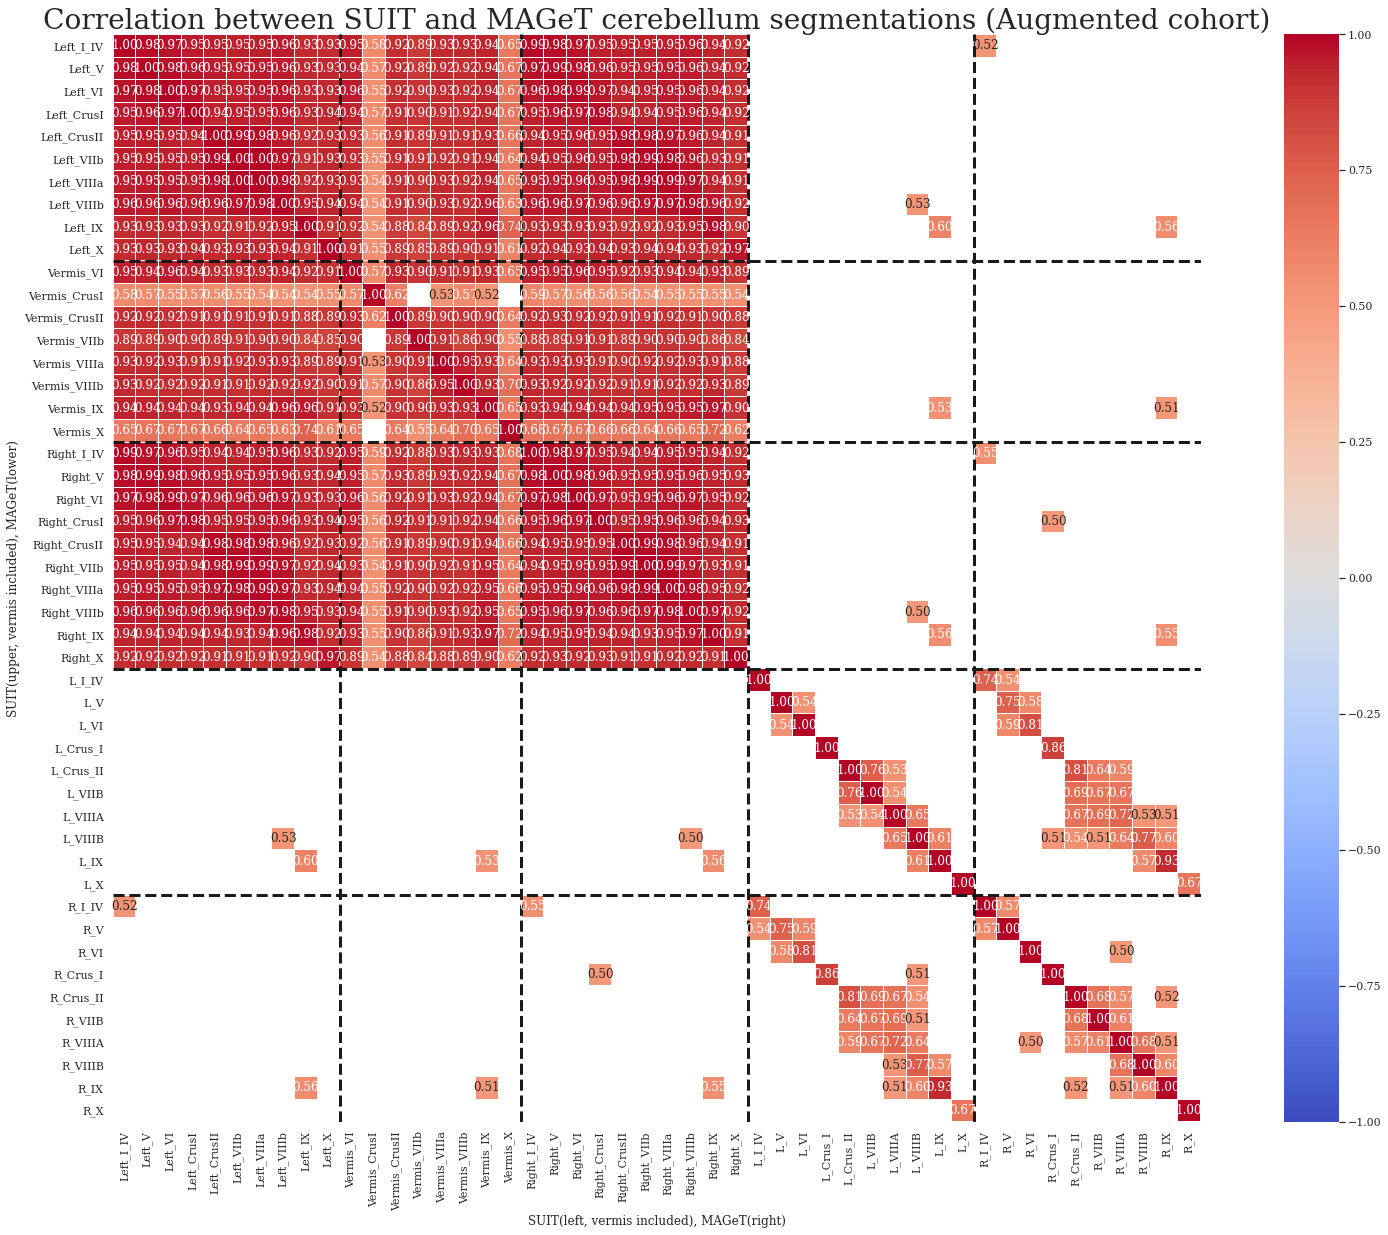

In [9]:
# Heatmap of full correlation between SUIT and MAGeT measures (Augmented NC)
# vis config
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

C_MAP='coolwarm'; TH=0.5
# select data
vis_df=data_df.copy()
vis_df=vis_df.loc[:,SUIT_l_labels[:length_lobule_list]+SUIT_v_labels+SUIT_r_labels[:length_lobule_list]+MAGeT_l_labels+MAGeT_r_labels]
# data proc
corr_=vis_df.corr()
mask_=corr_.where(np.abs(corr_)>TH, True).copy()
mask_=mask_.applymap(lambda x: False if isinstance(x, float) else True, na_action='ignore')

# Draw a heatmap with the numeric values in each cell
f1, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr_, ax=ax, annot=True, fmt=".2f", mask=mask_,
            vmax=1, vmin=-1, cmap=C_MAP, square=True, linewidths=.05)
ax.set_ylabel("SUIT(upper, vermis included), MAGeT(lower)")
ax.set_xlabel("SUIT(left, vermis included), MAGeT(right)")
ax.set_title('Correlation between SUIT and MAGeT cerebellum segmentations (Augmented cohort)', fontsize=28)
line_pos=[length_lobule_list,length_lobule_list+len(SUIT_v_labels),length_lobule_list*2+len(SUIT_v_labels),length_lobule_list*3+len(SUIT_v_labels)]
for x in line_pos:
    plt.axhline(x, ls='--',c='k', lw=3); plt.axvline(x, ls='--',c='k', lw=3)
if save_fig: print('saving...'); f1.savefig("Augmented-Cohort_SUIT-MAGeT_comp.jpg")
display(corr_)

(51, 54)


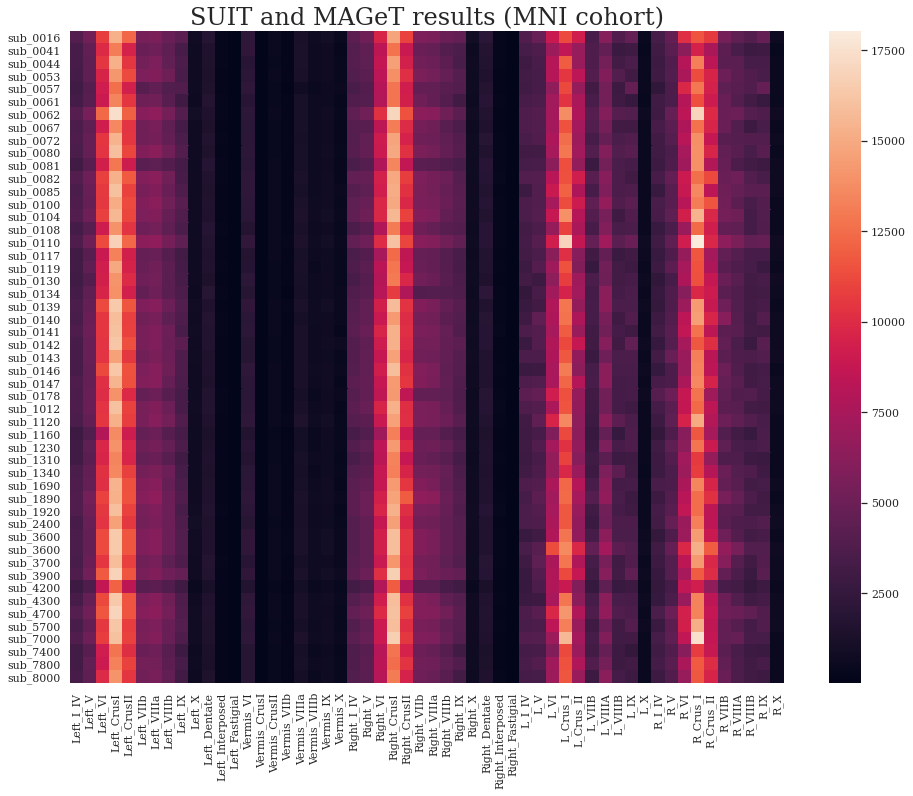

In [7]:
# visual inspection: Heatmap of SUIT and MAGeT measures
vis_df=data_df.loc[data_df['cohort']=='MNI'].copy()
vis_df=vis_df.loc[:,SUIT_l_labels+SUIT_v_labels+SUIT_r_labels+MAGeT_l_labels+MAGeT_r_labels]
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(vis_df, ax=ax)
ax.set_title('SUIT and MAGeT results (MNI cohort)', fontsize=24)
print(vis_df.shape)

(212, 54)


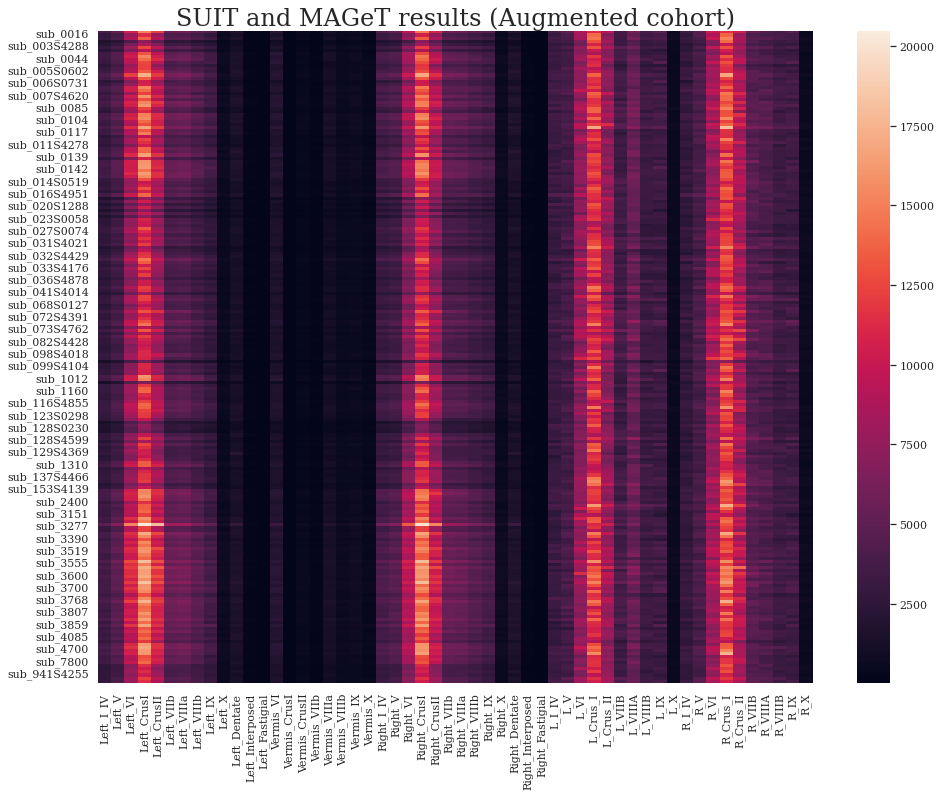

In [8]:
# Heatmap of results between SUIT and MAGeT measures (intercept)
vis_df=data_df.loc[:,SUIT_l_labels+SUIT_v_labels+SUIT_r_labels+MAGeT_l_labels+MAGeT_r_labels].copy()
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(vis_df, ax=ax)
ax.set_title('SUIT and MAGeT results (Augmented cohort)', fontsize=24)
print(vis_df.shape)